## This notebook does slew simulations, check all aos components (M1M3, M2, hexapods) behavior during the slew-and-track process, and applies MTAOS corrections for each visit.

This is expected to work both for SUMMIT and NCSA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

Patching auth into notebook.base.handlers.IPythonHandler(notebook.base.handlers.AuthenticatedHandler) -> IPythonHandler(jupyterhub.singleuser.mixins.HubAuthenticatedHandler, notebook.base.handlers.AuthenticatedHandler)


'andes06.cp.lsst.org'

In [3]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd
import logging

from lsst.ts.idl.enums import MTHexapod

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

Update leap second table
current_tai uses the system TAI clock


<Figure size 432x288 with 0 Axes>

In [4]:
summit = 1 #use this for summit testing
#summit = 0 #use this for NCSA

In [5]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/b1quint/WORK/ts_ddsconfig/config/ospl-shmem.xml
summit
0


In [6]:
logging.basicConfig(format="%(name)s:%(message)s", level=logging.DEBUG)

In [7]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

In [8]:
#index is an integter which helps avoid multple users starting same controller
index = os.geteuid() 
script = salobj.Controller("Script", index=index)

Read historical data in 0.00 sec


In [9]:
mtcs = MTCS(script.domain)
#mtcs.set_rem_loglevel(40)
mtcs.set_rem_loglevel(logging.CRITICAL) 

Read historical data in 0.08 sec
Read historical data in 0.09 sec
electrical DDS read queue is filling: 78 of 100 elements
electrical DDS read queue is full (100 elements); data may be lost
application DDS read queue is filling: 78 of 100 elements
application DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 80 of 100 elements
actuators DDS read queue is full (100 elements); data may be lost


In [10]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

In [11]:
mtcs.components_attr

['mtmount',
 'mtptg',
 'mtaos',
 'mtm1m3',
 'mtm2',
 'mthexapod_1',
 'mthexapod_2',
 'mtrotator',
 'mtdome',
 'mtdometrajectory']

In [12]:
ptg = mtcs.rem.mtptg
mount = mtcs.rem.mtmount
rot = mtcs.rem.mtrotator
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
aos = mtcs.rem.mtaos

### Get Ptg ready

In [13]:
await ptg.evt_heartbeat.next(flush=True, timeout=5)

In [14]:
await ptg.cmd_start.set_start()

In [15]:
await salobj.set_summary_state(ptg, salobj.State.ENABLED)

[<State.DISABLED: 1>, <State.ENABLED: 2>]

### Get Mount ready

In [16]:
await mount.evt_heartbeat.next(flush=True, timeout=5)

In [17]:
sim_evt = await mount.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  1 2021-08-03 16:48:27.672653056


In [18]:
a = await mount.evt_softwareVersions.aget(timeout=5)
print('software version? ', a.cscVersion, pd.to_datetime(a.private_sndStamp, unit='s'))

software version?  0.18.1 2021-08-03 16:48:27.700623104


In [19]:
a = await mount.evt_cameraCableWrapFollowing.aget()
print(a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

0 2021-08-03 16:51:59.982194176


The CCW is part of the mount. We need the CCW to follow the rotator. For that, we need to enable the CCW following. 

In [45]:
await salobj.set_summary_state(mount, salobj.State.OFFLINE)

[<State.ENABLED: 2>,
 <State.DISABLED: 1>,
 <State.STANDBY: 5>,
 <State.OFFLINE: 4>]

To bring the Mount online again, you need to log in to https://summit-lsp.lsst.codes/argo-cd. You can do it with GitHub. You will need special permissions for that. 

In [36]:
a = await mount.evt_cameraCableWrapFollowing.aget()
print(a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

1 2021-08-05 16:20:57.512974848


In [ ]:
await salobj.set_summary_state(mount, salobj.State.STANDBY)

In [ ]:
await mount.cmd_start.set_start()

In [35]:
await salobj.set_summary_state(mount, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [23]:
a = await mount.evt_cameraCableWrapFollowing.aget()
print(a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

1 2021-08-05 16:09:17.034736640


### Get Rotator ready

In [24]:
await checkSlewCompStates(ptg, mount, rot)

staring with: ptg state State.ENABLED 2021-08-05 16:00:42.262149120
staring with: mount state State.ENABLED 2021-08-05 16:09:17.035884288
staring with: rot state State.FAULT 2021-08-05 15:56:00.060858368


In [ ]:
await salobj.set_summary_state(rot, salobj.State.OFFLINE)

In [37]:
await rot.cmd_clearError.set_start()

In [38]:
await salobj.set_summary_state(rot, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [27]:
a=await mount.tel_cameraCableWrap.next(flush=True, timeout=5)
print(pd.to_datetime(a.private_sndStamp, unit='s'), a.actualPosition)

2021-08-05 16:13:41.467858944 0.11314002618843837


In [28]:
sim_evt = await rot.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  0 2021-07-30 15:13:04.283564544


In [29]:
a = await mount.tel_elevation.next(flush=True, timeout=5)
print("mount elevation Angle = ", a.actualPosition)
a = await mount.tel_azimuth.next(flush=True, timeout=5)
print("mount azimuth angle = ", a.actualPosition)
a = await mount.tel_cameraCableWrap.next(flush=True, timeout=5)
print("CCW angle = ", a.actualPosition, " Needs to be within 2.2 deg of rotator angle ")
b = await rot.tel_rotation.next(flush=True, timeout=5)
print("rot angle = ", b.actualPosition, "   diff = ", (b.actualPosition - a.actualPosition))

mount elevation Angle =  80.0
mount azimuth angle =  0.0
CCW angle =  0.11314002618843837  Needs to be within 2.2 deg of rotator angle 
rot angle =  0.11325102356127559    diff =  0.000110997372837221


In [30]:
a = await rot.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

Camera cable wrap telemetry is too old: dt=158143.02730822563; abs(dt) > 1 2021-08-05 15:56:00.012043008


In [55]:
a = await mount.evt_cameraCableWrapFollowing.aget(timeout=5.)
print(a.enabled)

1


(Depracated?) If the Camera Cable Warp is not following:
Transition the MTMount to StandbyState, wait 10 seconds, transition to EnableState.

Updated: Transition the MTMount to `DISABLED`, wait 10 seconds, transition to `ENABLED`.

In [40]:
await salobj.set_summary_state(mount, salobj.State.OFFLINE)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

Holger is bringing MTMount back to STANDBY via ArgoCD again.

In [46]:
await salobj.set_summary_state(mount, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [47]:
await rot.cmd_clearError.set_start()

In [48]:
await salobj.set_summary_state(rot, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [50]:
await mount.cmd_enableCameraCableWrapFollowing.set_start()

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=690344822, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: RuntimeError('<DeviceId.CAMERA_CABLE_WRAP: 4> off')")

In [53]:
await salobj.set_summary_state(mount, salobj.State.DISABLED)

[<State.ENABLED: 2>, <State.DISABLED: 1>]

In [54]:
await salobj.set_summary_state(mount, salobj.State.ENABLED)

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
await rot.cmd_clearError.set_start()

In [ ]:
await rot.cmd_start.set_start()

In [ ]:
await salobj.set_summary_state(mount, salobj.State.DISABLED)
await salobj.set_summary_state(mount, salobj.State.ENABLED)
a = await mount.evt_cameraCableWrapFollowing.aget()
print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

In [ ]:
await rot.cmd_move.set_start(0)

### Get MTAOS Ready

In [75]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [76]:
await salobj.set_summary_state(aos, salobj.State.ENABLED) #, settingsToApply='default') #leave this out!!
#two levels of defaults: csc defaults, config repo; right now csc defaults, they will move to config repo; 
#but to load defaults from config repo, we do not need to supply settingsToApply

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [77]:
a = await aos.evt_softwareVersions.aget(timeout=5)
print('software version? ', a.cscVersion, pd.to_datetime(a.private_sndStamp, unit='s'))

#this is MTAOS version. How do I get OFC version? and WEP version?

software version?  v0.7.1 2021-07-29 23:37:54.709229824


In [78]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

### Check that all components are ready

In [56]:
await checkAOSCompStates(m1m3, m2, camhex, m2hex)

starting with: M1M3 state State.ENABLED 2021-08-05 16:44:21.722770432
          detailed state DetailedState.PARKED 2021-08-05 16:44:21.722823168
staring with: m2 state State.STANDBY 2021-08-05 16:39:55.245746688
staring with: cam hex state State.STANDBY 2021-08-05 15:52:15.867863040
          cam hex state EnabledSubstate.STATIONARY 2021-08-05 15:52:22.214454528
staring with: M2 hex state State.OFFLINE 2021-07-30 00:32:55.027788288
          hex state EnabledSubstate.STATIONARY 2021-07-30 00:32:55.028018176


In [ ]:
await checkSlewCompStates(ptg, mount, rot)

In [ ]:
await checkAOSSummaryStates(aos, m1m3,m2,camhex,m2hex)

### Get M1M3 ready (Mount telemetry mode)

@bxin

Here is a bit of cheating so we can actually perform these tests without having M1M3 installed on the MTMount. We need to move the telescope to Zenith before we lift the mirror. If the Mount is nearly Zenith, but not quite at Zenith, it will think we should have forces applied to the mirror. Now, M1M3 is sitting on Level-3 pointing up. 

So, before we can start "slewing" (remember that we are in a partially simulated environment), we need to tell the (simulated) Mount to go to Zenith, then we can lift M1M3. 

In [57]:
#Move to zenith (so that we can start m1m3 with LUT in mount telemetry mode)
await mount.cmd_moveToTarget.set_start(azimuth=0, elevation=90)

In [51]:
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

Check that the M1M3 is in mount telemetry mode.  For this you have to login to m1m3-crio-ss.cp.lsst.org!!

In [79]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

[<State.FAULT: 3>, <State.STANDBY: 5>]

In [80]:
print('Re-enabling M1M3')
#await salobj.set_summary_state(m1m3, salobj.State.STANDBY) 
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

Re-enabling M1M3


[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

This command runs several things, including raising M1M3. This should take about ~4 min. 

In [81]:
await readyM1M3(m1m3)

m1m3 inclinometer Angle =  90.00800323486328
m1m3 state DetailedState.RAISING 2021-08-05 18:19:00.346834944
m1m3 state DetailedState.ACTIVE 2021-08-05 18:24:13.233254656
m1m3 z position =  6.260451357320562e-08
Magnitude of the m1m3 force balance system 190.2731170654297


In [ ]:
await m1m3.cmd_abortRaiseM1M3.set_start(timeout=15.)

In [82]:
await checkM1M3Error(m1m3)

Error cleared 2021-08-05 18:18:45.115485184


In [ ]:
await lowerM1M3(m1m3)

In [ ]:
m1m3.

### Get M2 ready

In [60]:
await m2.evt_heartbeat.next(flush=True, timeout=5)

In [61]:
await checkAOSCompStates(m1m3,m2,camhex,m2hex)

starting with: M1M3 state State.FAULT 2021-08-05 17:32:40.809137408
          detailed state DetailedState.FAULT 2021-08-05 17:32:40.809178624
staring with: m2 state State.STANDBY 2021-08-05 16:39:55.245746688
staring with: cam hex state State.STANDBY 2021-08-05 15:52:15.867863040
          cam hex state EnabledSubstate.STATIONARY 2021-08-05 15:52:22.214454528
staring with: M2 hex state State.OFFLINE 2021-07-30 00:32:55.027788288
          hex state EnabledSubstate.STATIONARY 2021-07-30 00:32:55.028018176


In [ ]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE) 

In [ ]:
await salobj.set_summary_state(m2, salobj.State.STANDBY) 

In [ ]:
await salobj.set_summary_state(m2, salobj.State.DISABLED) 

In [62]:
#remember to reset interlock
await salobj.set_summary_state(m2, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
a = await m2.evt_errorCode.aget()
print(a.errorCode, a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

In [ ]:
await m2.cmd_enterControl.set_start(timeout=.5)

In [ ]:
await m2.cmd_exitControl.set_start(timeout=.5)

In [ ]:
await m2.cmd_enable.set_start(timeout=5.)

In [ ]:
await m2.cmd_disable.set_start(timeout=5.)

In [ ]:
await m2.cmd_clearErrors.set_start(timeout=15.)

This command prints out a few things and make sure that the M2 force balance is turned on. 
It also makes sure we only have the LUT forces applied.

In [63]:
await readyM2(m2)

m2 inclinometer angle =  -0.12108245639986757
Inclinometer Source InclinationTelemetrySource.ONBOARD  ,event time =  2021-08-05 17:42:24.389880064
Status of the M2 force balance system True
clear any M2 activeopticForces (or any other hunman-applied forces)


### Get camHex ready

In [66]:
target_evt = await mount.evt_target.aget(timeout=5.)
print("Mount target elevation = ", target_evt.elevation, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))
print("Mount target azimuth   = ", target_evt.azimuth, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))
target_evt = await rot.evt_target.aget(timeout=5.)
print("Rotator target position = ", target_evt.position, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))

Mount target elevation =  90.0   @   2021-08-05 16:58:06.821713152
Mount target azimuth   =  0.0   @   2021-08-05 16:58:06.821713152
Rotator target position =  10.0   @   2021-08-05 17:51:37.971109632


In [104]:
#if any of the above doesn't work
#await mount.cmd_moveToTarget.set_start(azimuth=0, elevation=81)
await rot.cmd_move.set_start(position=0)

In [67]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [68]:
sim_evt = await camhex.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  0 2021-07-30 15:13:02.417262848


In [ ]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

In [ ]:
await camhex.cmd_clearError.set_start()

In [ ]:
await salobj.set_summary_state(camhex, salobj.State.DISABLED, settingsToApply='default')

In [70]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply='default')

[<State.DISABLED: 1>, <State.ENABLED: 2>]

Move the Pivot point by 100um to make sure that the configuration event gets published

In [ ]:
await camhex.cmd_setPivot.set_start(x=0,y=0,z=-2758300)

In [ ]:
await camhex.cmd_setPivot.set_start(x=0,y=0,z=-2758400)

The following cell does a small move on the Camera-Hexapod. This information might be important in the case of having someone working on there.

In [71]:
await readyHexaForAOS(camhex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-08-05 17:54:29.775492608
pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled? True 2021-08-05 17:57:13.117309184
hexa in position? True 2021-08-05 17:57:14.760392448
Current Hexapod position
     -1.05    -653.17     395.90  -0.017752   0.000003  -0.000004
hexa in position? False 2021-08-05 17:57:14.980408064
hexa in position? True 2021-08-05 17:57:16.471786496
Current Hexapod position
     -0.63    -653.40     295.32  -0.017760  -0.000004  -0.000003
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-08-05 17:57:14.805938176
Compensated position
     -0.93    -652.98     295.56      -0.017752   0.000000   0.000000    2021-08-05 17:57:14.806138624
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  90.0
mount azimth =  0.0
rotato

In [ ]:
await printHexaUncompensatedAndCompensated(m2hex)

In [ ]:
await printHexaUncompensatedAndCompensated(camhex)

In [102]:
await camhex.cmd_setCompensationMode.set_start(enable=False)

In [103]:
await moveHexaTo0(camhex)

hexa in position? False 2021-08-05 19:48:25.686096896
hexa in position? True 2021-08-05 19:48:26.177026048
Current Hexapod position
     -0.73      -0.56      -0.11  -0.000015   0.000020  -0.000021


### Get m2Hex ready

In [72]:
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply='default') #works if it is offline

[<State.OFFLINE: 4>,
 <State.STANDBY: 5>,
 <State.DISABLED: 1>,
 <State.ENABLED: 2>]

In [73]:
sim_evt = await m2hex.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  1 2021-07-30 00:32:55.031098112


In [74]:
await readyHexaForAOS(m2hex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-08-05 18:03:07.015081728
pivot at (0, 0, 500000) microns 
maxXY =  10500.0 microns, maxZ=  8900.0  microns
maxUV =  0.175 deg, maxW=  0.05  deg
compsensation mode enabled? True 2021-08-05 18:03:19.142047488
hexa in position? True 2021-08-05 18:03:20.288166400
Current Hexapod position
     -1.85    -572.64     404.71  -0.006649   0.000000  -0.000000
hexa in position? False 2021-08-05 18:03:20.490022656
hexa in position? True 2021-08-05 18:03:20.590646528
Current Hexapod position
     -1.87    -572.55     304.73  -0.006649  -0.000000  -0.000000
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-08-05 18:03:20.397093888
Compensated position
     -1.84    -572.60     304.70      -0.006649   0.000000   0.000000    2021-08-05 18:03:20.397297664
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  90.0
mount azimth =  0.0
rotator

In [ ]:
end = Time(datetime.now(), scale='tai')
start = end - timedelta(seconds=1000)
df = await client.select_time_series('lsst.sal.ESS.temperature8Ch', '*', start, end, csc_index)
if len(df)>0:
    fig, ax = plt.subplots(1,1, figsize=(15,4))
    for i in range(1,7):
        plt.plot(getattr(df, 'temperatureC%02d'%i))
    plt.grid()
else:
    print('No temperature data on the camera hexapod in the past 1000s.')

### Do a few slews

In [ ]:
await m1m1.error

#### Do 4 slews, then stop tracking

In [84]:
#comment and uncomment the below depending on which components are expected to be on
#by default, MTCS checks on every component (during the slew).
mtcs.check.mtaos = True
mtcs.check.mtm1m3 = True
mtcs.check.mtm2 = True
mtcs.check.mthexapod_1 = True
mtcs.check.mthexapod_2 = True
mtcs.check.mtdome = False
mtcs.check.mtdometrajectory = False

In [85]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
await aos.cmd_setLogLevel.set_start(level=10, timeout=5)

CCW folowing?  1 2021-08-05 16:47:41.010509056
moving from elevation 90.0 deg to 82.4 deg 2021-08-05 18:38:52.209601
This will run for 366 seconds
No inPosition event seen. Continuing
start a slew, elevation diff =  0.08536760849113989 2021-08-05 18:47:11.856386
CCW folowing?  1 2021-08-05 16:47:41.010509056
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the camera hexapod correction successfully.
10: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the M1M3 correction successfully.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodC

Got False
Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


CCW folowing?  1 2021-08-05 16:47:41.010509056
moving from elevation 82.7 deg to 84.7 deg 2021-08-05 18:48:22.438792
This will run for 97 seconds
rot in position? True 2021-08-05 18:51:03.163902976
start a slew, elevation diff =  0.09641008721085598 2021-08-05 18:50:26.169903
CCW folowing?  1 2021-08-05 16:47:41.010509056
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEv

Got False
Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


CCW folowing?  1 2021-08-05 16:47:41.010509056
moving from elevation 84.9 deg to 82.4 deg 2021-08-05 18:51:39.207786
This will run for 120 seconds
rot in position? True 2021-08-05 18:55:05.704686592
start a slew, elevation diff =  0.07811936509668271 2021-08-05 18:54:28.723184
CCW folowing?  1 2021-08-05 16:47:41.010509056
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Issue the camera hexapod correction successfully.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubE

Got False
Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


CCW folowing?  1 2021-08-05 16:47:41.010509056
moving from elevation 82.6 deg to 84.7 deg 2021-08-05 18:55:38.517165
This will run for 102 seconds
rot in position? True 2021-08-05 18:58:45.196329472
start a slew, elevation diff =  0.08044485111317101 2021-08-05 18:58:08.203942
CCW folowing?  1 2021-08-05 16:47:41.010509056
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_issueCorrection().
10: Issue the M1M3 correction successfully.
10: Issue the M2 correction successfully.
10: Issue the camera hexapod correction successfully.
10: Issue the M2 hexapod correction successfully.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubE

Got False
Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


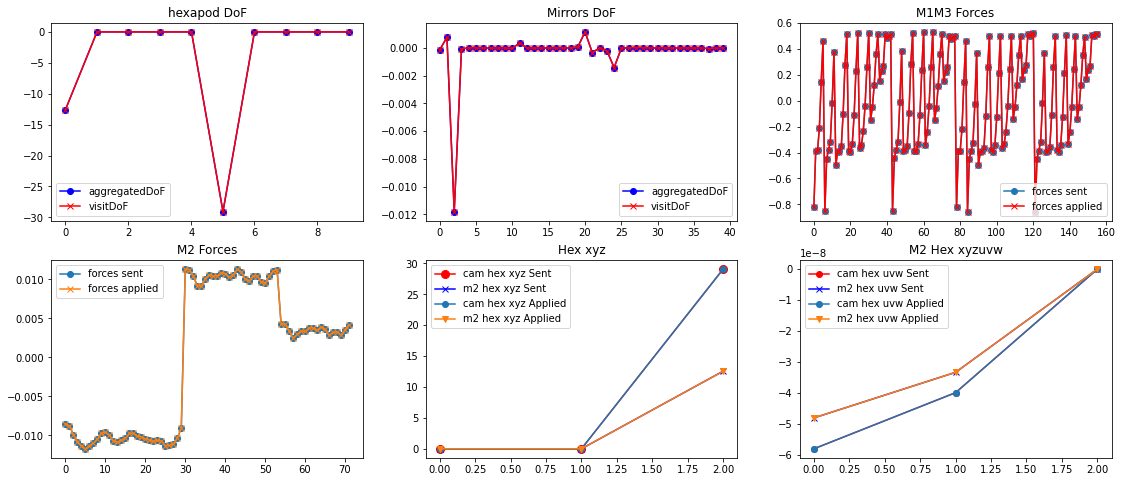

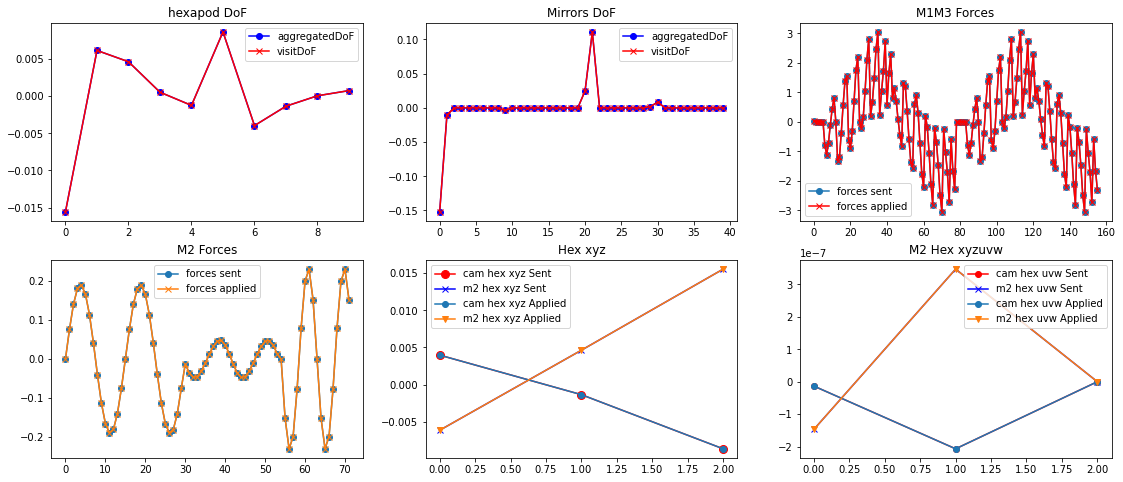

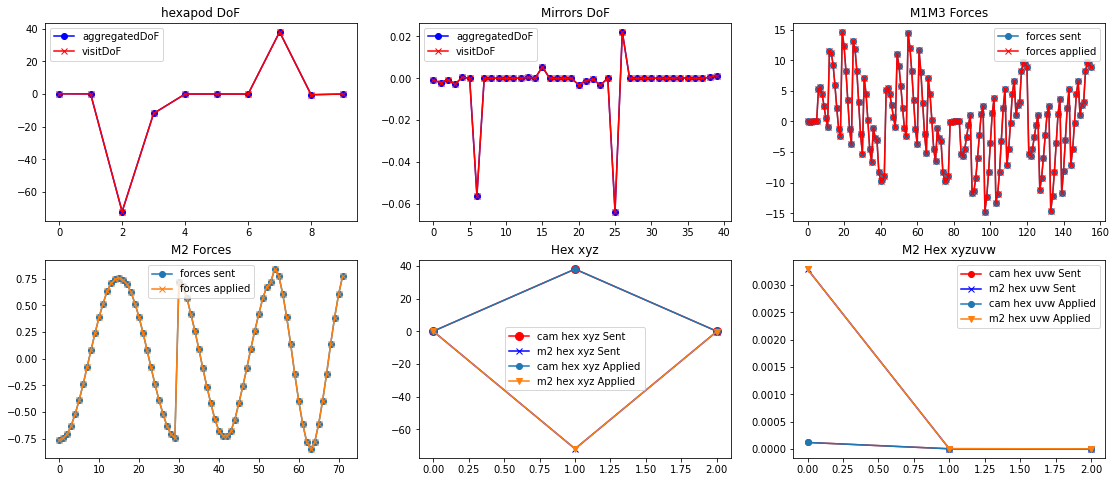

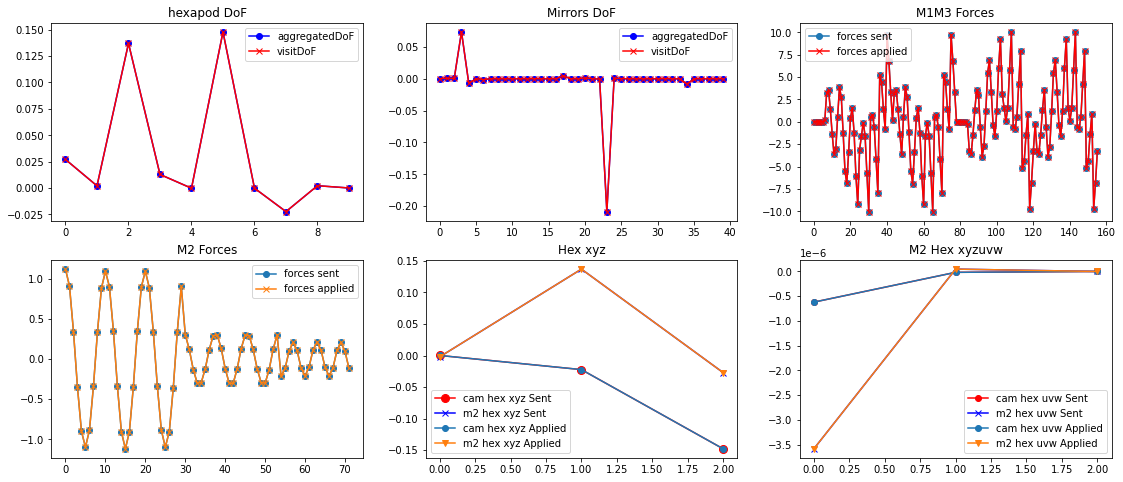

In [86]:
dec = -34.
for j in range(2):
    for i in range(2):
        
        a = await mount.evt_cameraCableWrapFollowing.aget()
        print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))
        if not a.enabled:
            break
        time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
        ra = time_and_date.lst + 0.5 - 3.5/15.0 * i
        
        aa = await mount.tel_elevation.next(flush=True, timeout=5.)
        current_el = aa.actualPosition
        
        obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 0.) #with 0s delay
        azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
        target_el = azel.alt.value
        
        while abs(target_el - current_el)>0.3:
            print('moving from elevation %.1f deg to %.1f deg'%(current_el, target_el), Time.now())
            await moveMountConstantV(mount, current_el, target_el)
        
            aa = await mount.tel_elevation.next(flush=True, timeout=5.)
            current_el = aa.actualPosition
        
            time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
            ra = time_and_date.lst + 0.5 - 3.5/15.0 * i
    
            obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 0.) #with 0s delay
            azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
            target_el = azel.alt.value
        
        await moveRotTo0(rot, 10.0)
        
        print('start a slew, elevation diff = ', abs(target_el - current_el), Time.now())
        a = await mount.evt_cameraCableWrapFollowing.aget()
        print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))
        if not a.enabled:
            break
            
        await aos.cmd_resetCorrection.set_start()
        await aos.cmd_issueCorrection.set_start() 
        k = j*2+i
        zernikes = np.zeros(19)
        if k==0:
            zernikes[4-4] = 1 #add 1um of z4
        elif k==1:
            zernikes[5-4] = 1 #add 1um of z5
        elif k==2:
            zernikes[7-4] = 1 #add 1um of z7
        elif k==3:
            zernikes[9-4] = 1 #add 1um of z9
        await aos.cmd_addAberration.set_start(wf = zernikes)
        await aos.cmd_issueCorrection.set_start() 
        await asyncio.sleep(2.0)

        ofc_dict =  await ofcSentApplied(aos, m1m3, m2, camhex, m2hex, make_plot = True)

        rotAngle = 10.0
        print('zero-indexed: ', k, 'rot = ', rotAngle)
        #b = await mount.tel_cameraCableWrap.next(flush=True, timeout=5) #CCW doesn't follow rotator!!!
        # await mtcs.slew_icrs(ra=ra, dec=dec, rot=b.actualPosition, rot_type=RotType.PhysicalSky)
        await mtcs.slew_icrs(ra=ra, dec=dec, rot=rotAngle, rot_type=RotType.PhysicalSky)
        #await mtcs.slew_icrs(ra=ra, dec=dec, rot=0.0, rot_type=RotType.Physical)
        await asyncio.sleep(39.)
        await mtcs.stop_tracking()

In [87]:
await mtcs.stop_tracking()

#### Plot the above process

In [90]:
#end = Time(datetime.now(), scale='tai')
end = Time('2021-08-05T19:05:00', scale='tai')
start = end - timedelta(seconds=1000)

In [89]:
dfm2

NameError: name 'dfm2' is not defined

In [91]:
dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedElevationForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.application', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

electrical DDS read queue is filling: 16 of 100 elements
actuators DDS read queue is filling: 35 of 100 elements
application DDS read queue is filling: 72 of 100 elements
electrical DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 61 of 100 elements
application DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 77 of 100 elements
actuators DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 15 of 100 elements
electrical DDS read queue is filling: 17 of 100 elements
application DDS read queue is filling: 20 of 100 elements
Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Text(0.5, 1.0, 'Changes in telemetry')

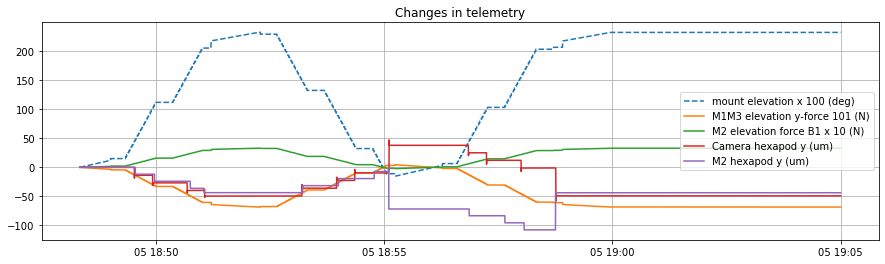

In [92]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot((dfm.actualPosition-dfm.actualPosition[0])*100, '--', label='mount elevation x 100 (deg)')
plt.plot(dfm1m3.yForces0-dfm1m3.yForces0[0], label='M1M3 elevation y-force 101 (N)')
plt.plot((dfm2.lutGravity0-dfm2.lutGravity0[0])*10, label='M2 elevation force B1 x 10 (N)')
plt.plot(dfh1.position1-dfh1.position1[0], label='Camera hexapod y (um)')
plt.plot(dfh2.position1-dfh2.position1[0], label='M2 hexapod y (um)')
plt.grid()
plt.legend()
plt.title('Changes in telemetry')

#### Check if the telescope is in tracking mode. If yes, need to stop stacking.

The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [98]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

Are we tracking? False


In [ ]:
await mtcs.stop_tracking()

### put mount elevation back to 90 deg, so that we can lower M1M3

In [94]:
aa = await mount.tel_elevation.next(flush=True, timeout=5.)
current_el = aa.actualPosition

In [95]:
await moveMountConstantV(mount,current_el, 90)

This will run for 245 seconds


In [97]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-08-05 19:39:45.845725952
m1m3 state DetailedState.PARKED 2021-08-05 19:42:04.786023424


#### Close up. Put all simulators to standby

In [ ]:
await mtcs.stop_tracking()

In [107]:
await salobj.set_summary_state(aos, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [110]:
await salobj.set_summary_state(ptg, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [109]:
await salobj.set_summary_state(mount, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [108]:
await salobj.set_summary_state(rot, salobj.State.OFFLINE)

[<State.ENABLED: 2>,
 <State.DISABLED: 1>,
 <State.STANDBY: 5>,
 <State.OFFLINE: 4>]

In [105]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [ ]:
await camhex.cmd_disable.set_start()

In [ ]:
await salobj.set_summary_state(camhex, salobj.State.DISABLED)

In [106]:
await salobj.set_summary_state(m2hex, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [ ]:
await salobj.set_summary_state(m2, salobj.State.DISABLED)

In [ ]:
await salobj.set_summary_state(m2, salobj.State.STANDBY)

In [96]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE)

[<State.ENABLED: 2>,
 <State.DISABLED: 1>,
 <State.STANDBY: 5>,
 <State.OFFLINE: 4>]

In [ ]:
await lowerM1M3(m1m3)

In [99]:
await salobj.set_summary_state(m1m3, salobj.State.OFFLINE)

[<State.ENABLED: 2>,
 <State.DISABLED: 1>,
 <State.STANDBY: 5>,
 <State.OFFLINE: 4>]

In [ ]:
await salobj.set_summary_state(mount, salobj.State.STANDBY)

In [ ]:
await rot.cmd_clearError.set_start()

In [ ]:
await m2.cmd_exitControl.set_start()

In [ ]:
await checkAOSCompStates(m1m3,m2,camhex, m2hex)

In [ ]:
await checkSlewCompStates(ptg,mount, rot)